In [18]:
from Bio import AlignIO
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio import Seq
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import json
import subprocess
import pylab

In [19]:
# input berupa file alignment
# format antara "clustal" atau "fasta"\
# baca selengkapnya di https://biopython.org/docs/1.76/api/Bio.AlignIO.html

def align_using_muscle(filepath):
    output = filepath.split(".")[:-1]
    output.append("_muscle")
    output = "".join(output) + ".fasta"
    if (filepath[0] == "."):
        output = "." + output
    print(output)
    os.system("muscle -align {0} -output {1}".format(filepath, output))
    # subprocess.Popen(["muscle", "-align", filepath, "-output", output])

def read_alignment(filepath):
    alignment = AlignIO.read(filepath, "fasta")
    alignment = MultipleSeqAlignment(alignment)
    return alignment

# hitung distance matrix dari file alignment
def calculate_distance_matrix(aln):
    calculator = DistanceCalculator('identity')
    distance_matrix = calculator.get_distance(aln)
    return distance_matrix

# bentuk pohon filogenetik dari distance matrix
# method antara "upgma" atau "nj"
# baca di https://homolog.us/Biopython/Bio.Phylo.TreeConstruction.DistanceTreeConstructor.html
def construct_tree(dm, method):
    constructor = DistanceTreeConstructor()
    if (method == "upgma"):
        tree = constructor.upgma(dm)
    else:
        tree = constructor.nj(dm)
    return tree

In [20]:
def generate_sequences_headers_ref_labels(sequences_list):
    ref = {}
    for sequences in sequences_list:
        for seq_record in sequences:
            ref[seq_record.id] = seq_record.description
    
    return ref

def generate_sequences_headers_ref_labels_to_file(sequences_list, output):
    ref = generate_sequences_headers_ref_labels(sequences_list)
    with open(output, "w") as outfile:
        json.dump(ref, outfile)
    
    
def label_func_all(clade):
    name  = clade.name
    matches = re.findall("Inner", name)
    if (len(matches) > 0):
        return '{0:.4f}'.format(clade.branch_length)
    return clade.name

def label_func_non_zero(clade):
    name  = clade.name
    matches = re.findall("Inner", name)
    if (len(matches) > 0):
        if (clade.branch_length > 0.00):
            return '{0:.4f}'.format(clade.branch_length)
        return '0.0'
    return clade.name

def label_func_non_zero_alt(clade):
    name  = clade.name
    branch_length = clade.branch_length
    postfix = ''
    prefix = ''
    matches = re.findall("^Inner", name)
    if (len(matches) == 0):
        postfix = ' - ' + name
    if (branch_length > 0):
        prefix = '{0:.4f}'.format(branch_length)
    return prefix + postfix

def label_func_by_seqids(clade, ref):
    branch_length = clade.branch_length
    pattern = "^lcl\|([\w\.]+)_cds"
    matches = re.findall(pattern, clade.name)
    labels = []
    if (branch_length > 0):
        labels.append('{0:.4f}'.format(branch_length))
    if (len(matches) > 0):
        try:
            index = str(matches[0])
            labels.append(ref[index])
        except:
            labels.append(clade.name)
    return " - ".join(labels)

In [26]:
align_using_muscle("./example_working_directory/search_result_1_orf1ab_1000.fasta")

./example_working_directory/search_result_1_orf1ab_1000_muscle.fasta



muscle 5.1.linux64 [5c1174]  15.7Gb RAM, 16 cores
Built Oct 15 2023 06:44:06
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 39 seqs, avg length 1000, max 1000

00:00 9.4Mb  CPU has 16 cores, running 16 threads


00:11 1.1Gb   100.0% Calc posteriors
00:12 1.1Gb   100.0% Consistency (1/2)
00:12 1.1Gb   100.0% Consistency (2/2)
00:12 1.1Gb   100.0% UPGMA5           
00:13 1.2Gb   100.0% Refining


In [24]:
aln = read_alignment("./example_working_directory/search_result_1_orf1ab_1000_muscle.fasta")

dis = calculate_distance_matrix(aln)
tree = construct_tree(dis, "upgma")
tree.ladderize()

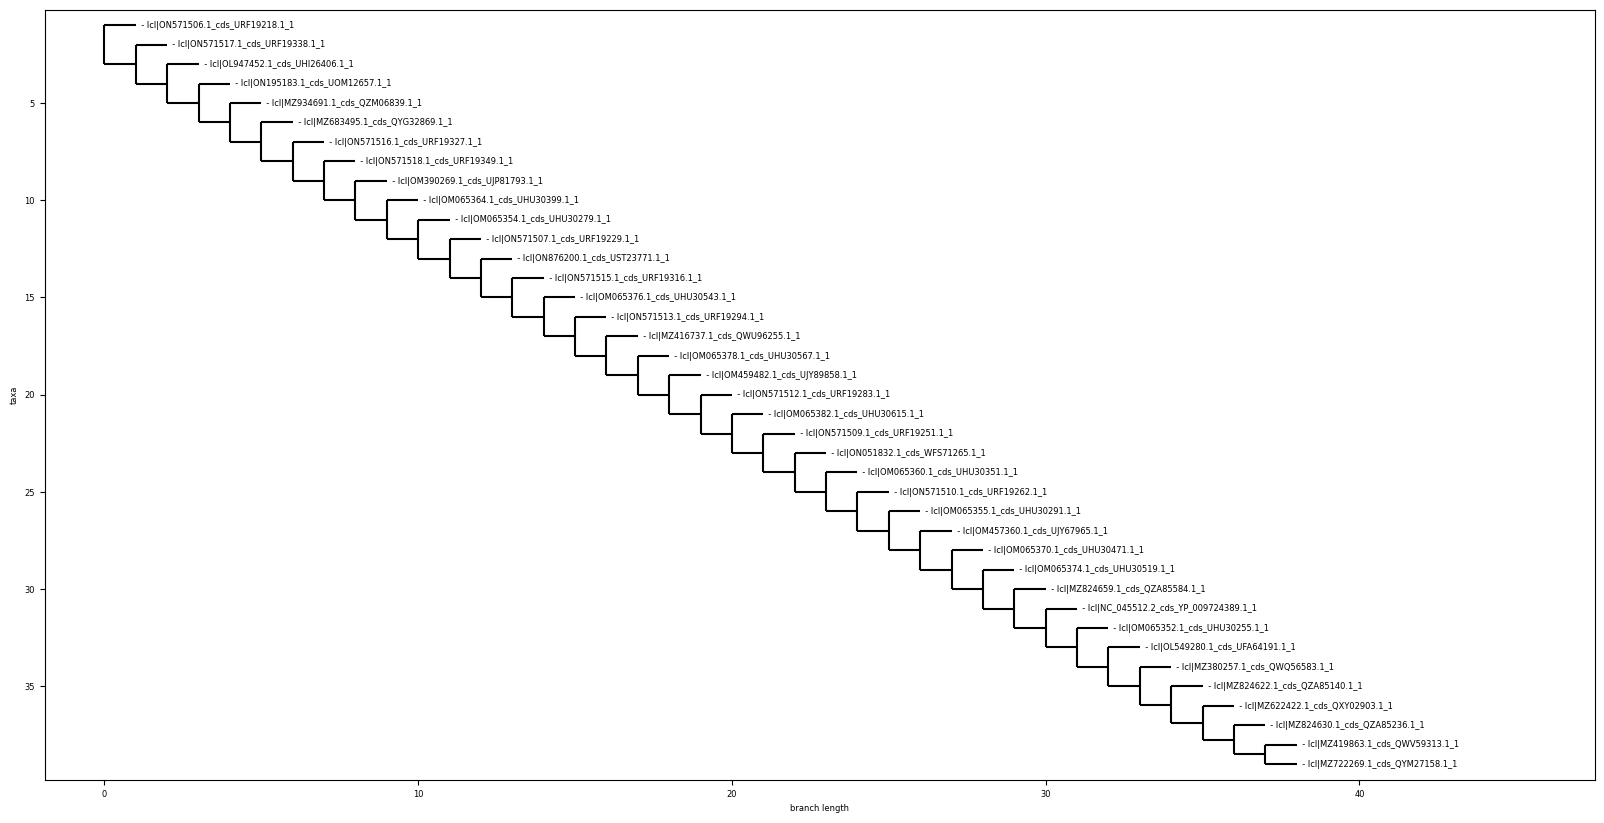

In [29]:
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(20, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

# using default fasta header
# Phylo.draw(tree, axes=axes, label_func=label_func_non_zero_alt, do_show=False)

# using metadata json
# using default fasta header
ref = generate_sequences_headers_ref_labels([
    SeqIO.parse("./02-blast-search/search_result_1.fasta", "fasta")
])
Phylo.draw(tree, axes=axes, label_func=lambda c: label_func_by_seqids(c, ref), do_show=False)

pylab.savefig('./example_working_directory/search_result_1_orf1ab_1000_tree.svg',format='svg', bbox_inches='tight', dpi=300)

In [7]:
align_using_muscle("./example_working_directory/search_result_2_orf1ab_1000.fasta")

./example_working_directory/search_result_2_orf1ab_1000_muscle.fasta


In [11]:
aln = read_alignment("./example_working_directory/search_result_2_orf1ab_1000_muscle.fasta")

dis = calculate_distance_matrix(aln)
tree = construct_tree(dis, "upgma")
tree.ladderize()

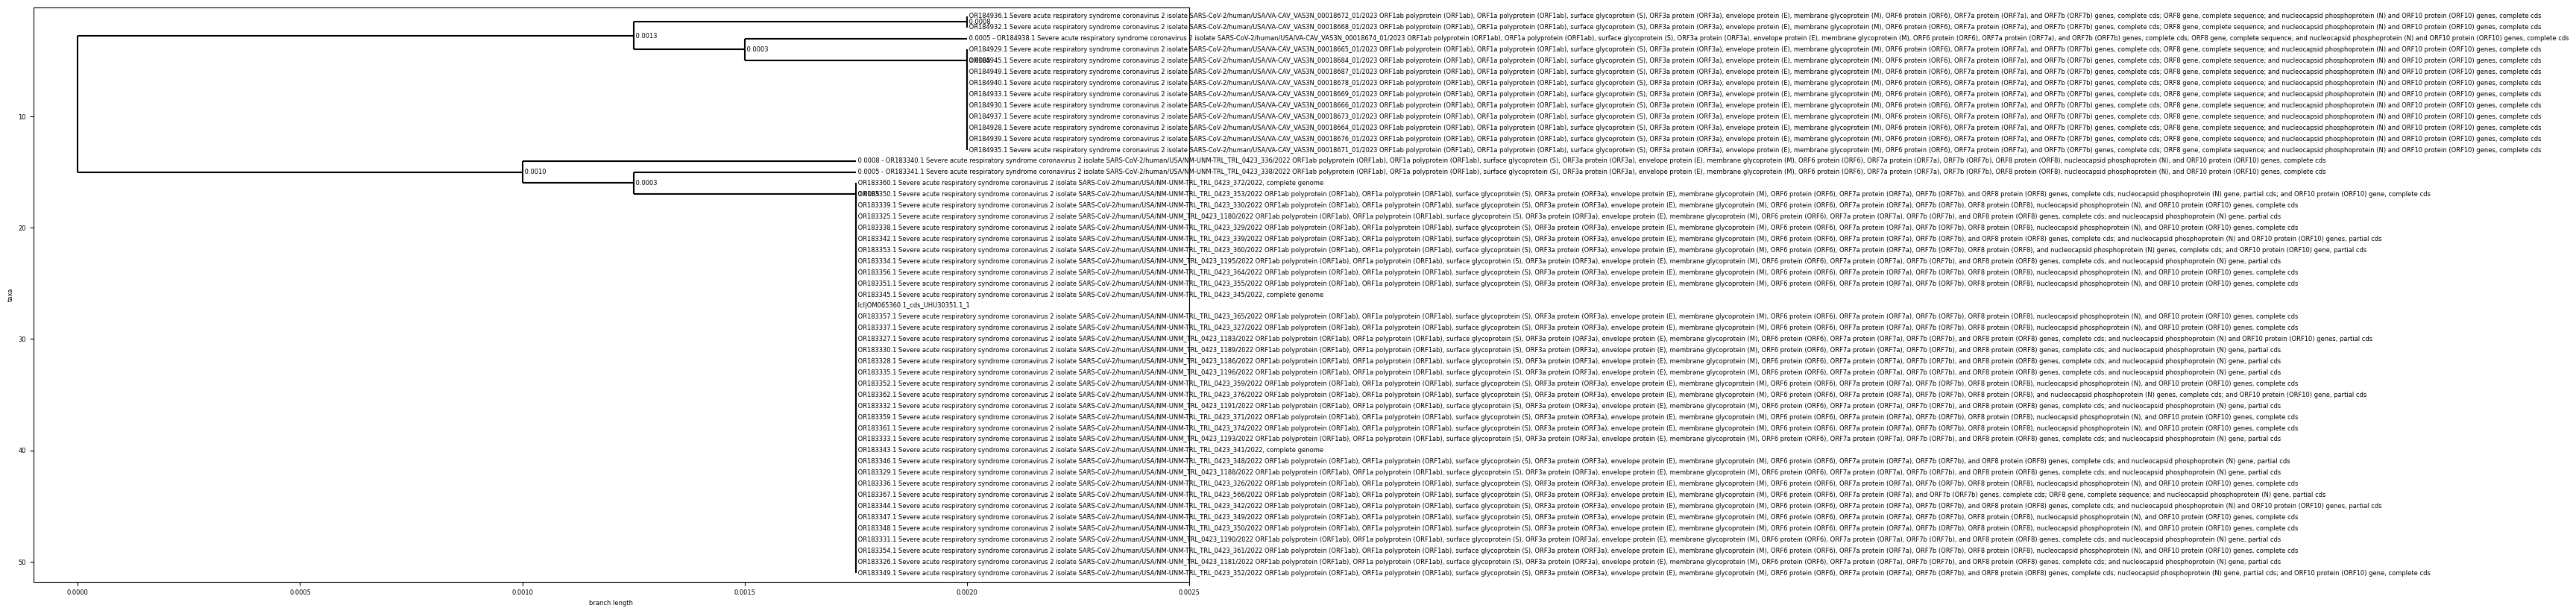

In [12]:
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(20, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

# using default fasta header
# Phylo.draw(tree, axes=axes, label_func=label_func_non_zero_alt, do_show=False)

# using metadata json
# using default fasta header
ref = generate_sequences_headers_ref_labels([
    SeqIO.parse("./02-blast-search/search_result_2.fasta", "fasta")
])
Phylo.draw(tree, axes=axes, label_func=lambda c: label_func_by_seqids(c, ref), do_show=False)

pylab.savefig('./example_working_directory/search_result_2_orf1ab_1000_tree.svg',format='svg', bbox_inches='tight', dpi=300)

In [10]:
align_using_muscle("./example_working_directory/search_result_3_orf1ab_1000.fasta")

./example_working_directory/search_result_3_orf1ab_1000_muscle.fasta


In [13]:
aln = read_alignment("./example_working_directory/search_result_3_orf1ab_1000_muscle.fasta")

dis = calculate_distance_matrix(aln)
tree = construct_tree(dis, "upgma")
tree.ladderize()

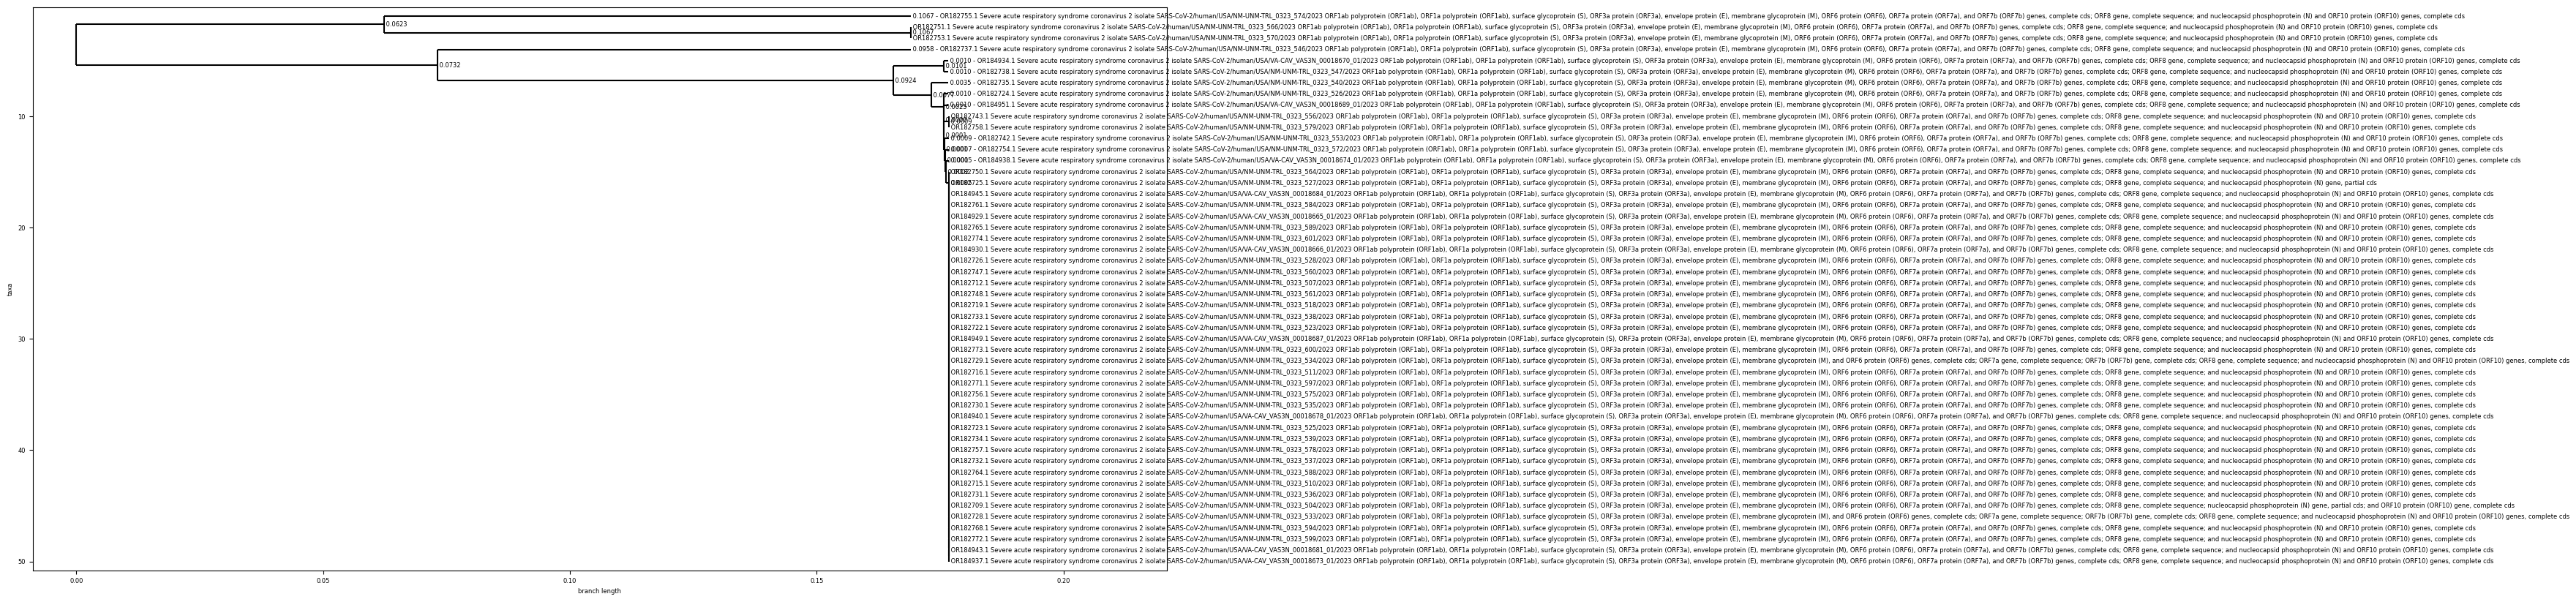

In [14]:
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(20, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

# using default fasta header
# Phylo.draw(tree, axes=axes, label_func=label_func_non_zero_alt, do_show=False)

# using metadata json
# using default fasta header
ref = generate_sequences_headers_ref_labels([
    SeqIO.parse("./02-blast-search/search_result_3.fasta", "fasta")
])
Phylo.draw(tree, axes=axes, label_func=lambda c: label_func_by_seqids(c, ref), do_show=False)

pylab.savefig('./example_working_directory/search_result_3_orf1ab_1000_tree.svg',format='svg', bbox_inches='tight', dpi=300)

In [15]:
align_using_muscle("./example_working_directory/merged_search_result_orf1ab_1000.fasta")

./example_working_directory/merged_search_result_orf1ab_1000_muscle.fasta



muscle 5.1.linux64 [5c1174]  15.7Gb RAM, 16 cores
Built Oct 15 2023 06:44:06
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

Input: 16 seqs, avg length 1000, max 1000

00:00 9.2Mb  CPU has 16 cores, running 16 threads
00:02 1.1Gb   100.0% Calc posteriors
00:02 1.1Gb   100.0% Consistency (1/2)
00:02 1.1Gb   100.0% Consistency (2/2)
00:02 1.1Gb   100.0% UPGMA5           
00:03 1.2Gb   100.0% Refining


In [16]:
aln = read_alignment("./example_working_directory/merged_search_result_orf1ab_1000.fasta")

dis = calculate_distance_matrix(aln)
tree = construct_tree(dis, "upgma")
tree.ladderize()

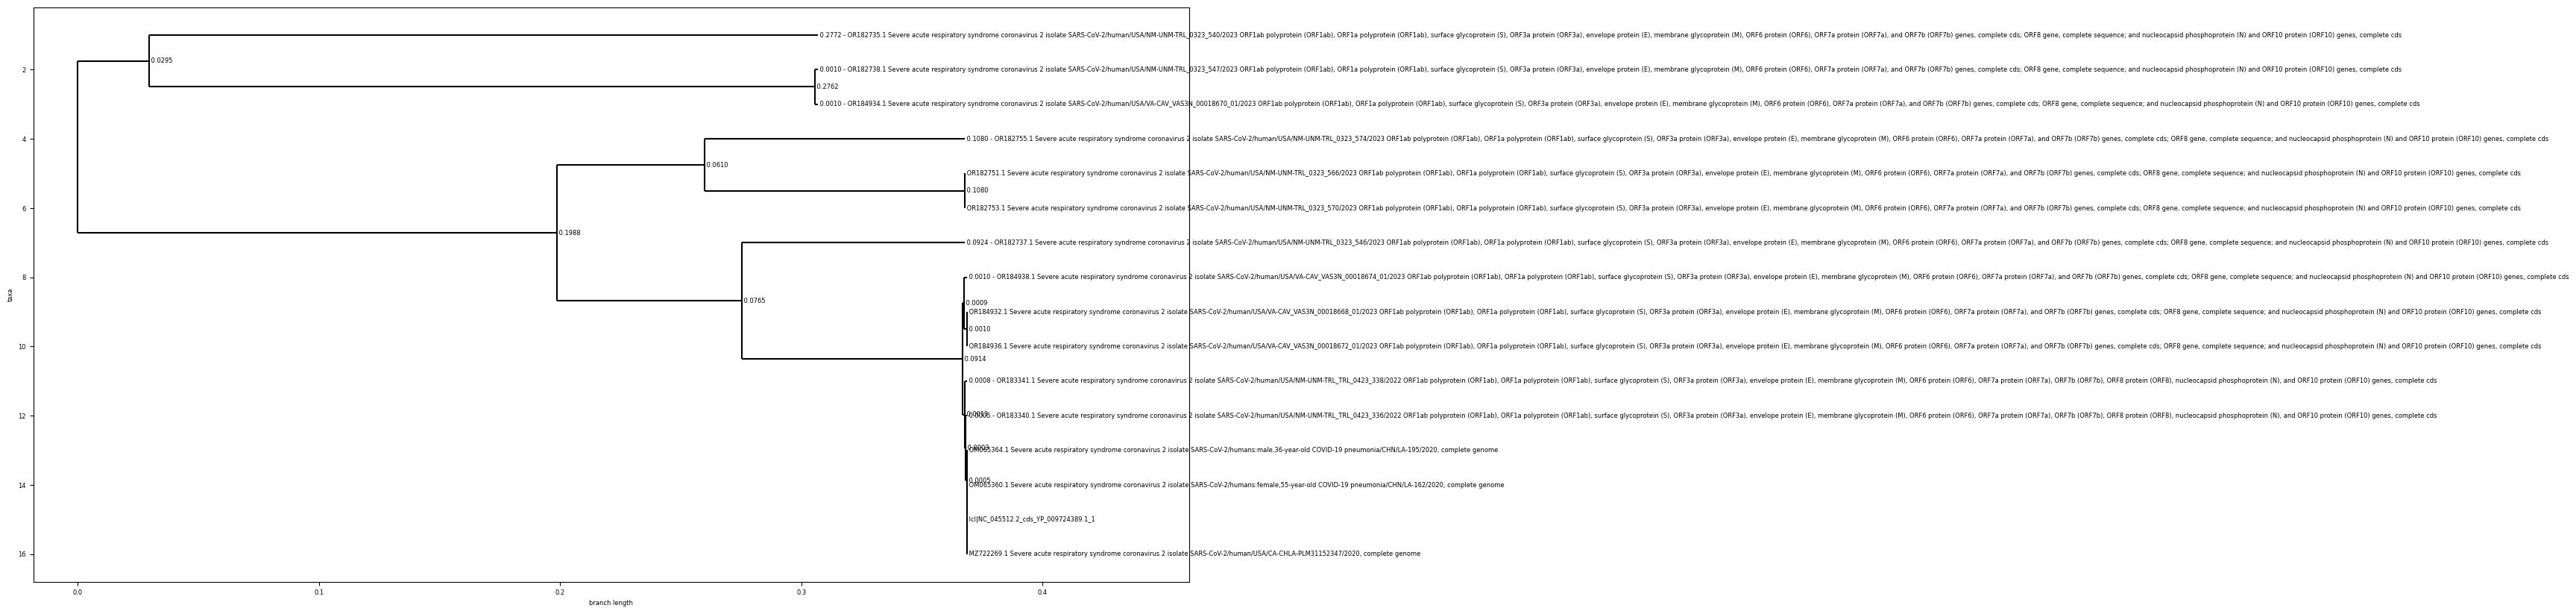

In [17]:
matplotlib.rc('font', size=6)
fig = plt.figure(figsize=(20, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

# using default fasta header
# Phylo.draw(tree, axes=axes, label_func=label_func_non_zero_alt, do_show=False)

# using metadata json
# using default fasta header
ref = generate_sequences_headers_ref_labels([
    SeqIO.parse("./02-blast-search/search_result_1.fasta", "fasta"),
    SeqIO.parse("./02-blast-search/search_result_2.fasta", "fasta"),
    SeqIO.parse("./02-blast-search/search_result_3.fasta", "fasta")
])
Phylo.draw(tree, axes=axes, label_func=lambda c: label_func_by_seqids(c, ref), do_show=False)

pylab.savefig('./example_working_directory/merged_search_result_orf1ab_1000_tree.svg',format='svg', bbox_inches='tight', dpi=300)